In [13]:
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import keras_tuner as kt

In [14]:
master_dataset = tf.keras.utils.image_dataset_from_directory(
    '../../data/trashnet/dataset-resized',
    labels='inferred',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 2527 files belonging to 6 classes.


In [15]:
class_names = master_dataset.class_names

In [16]:
def load_class_dataset(master_dataset, class_index, augment=False, num_samples=None):
    dataset = (master_dataset.unbatch()).filter(lambda x, y: tf.equal(y, class_index))

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"), # apply augmentation only if we have to make more images
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1)
        ])
        dataset = dataset.map(lambda x, y: (aug(x, training=True), y))

    if num_samples is not None:
        dataset = dataset.shuffle(buffer_size=num_samples, seed=123).repeat().take(num_samples)
    return dataset.batch(32)

In [17]:
batched_dataset = []
counts = [403, 501, 482, 594, 410, 137]
target_size = 400

for i, count in enumerate(counts):
    # need to cut out some of the images
    batched_dataset.append(load_class_dataset(master_dataset, i, count < target_size, target_size))

balanced_dataset = batched_dataset[0]
for dataset in batched_dataset[1:]:
    balanced_dataset = balanced_dataset.concatenate(dataset)

In [18]:
total_samples = target_size * len(class_names)
shuffled = balanced_dataset.unbatch().shuffle(total_samples, seed=123)

In [19]:
train_dataset = (
    shuffled.take(int(0.7 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    shuffled.skip(int(0.7 * total_samples)).take(int(0.2 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    shuffled.skip(int(0.9 * total_samples)).take(int(0.1 * total_samples)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
)

In [20]:
def model_builder(hyperparameter):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())

    hyperparameter_units = hyperparameter.Int('units', min_value=32, max_value=224, step=32)
    model.add(tf.keras.layers.Dense(units=hyperparameter_units, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names)))

    hyperparameter_learning_rate = hyperparameter.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameter_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [21]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_dir6',
                     project_name='intro_to_kt6')

In [22]:
tuner.search(train_dataset, epochs=50, validation_data=validation_dataset)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hyperparameters.get('units')} and the optimal learning rate for the optimizer
is {best_hyperparameters.get('learning_rate')}.
""")

Trial 30 Complete [00h 01m 35s]
val_accuracy: 0.550000011920929

Best val_accuracy So Far: 0.7770833373069763
Total elapsed time: 00h 19m 03s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.001.



In [23]:
model = tuner.hypermodel.build(best_hyperparameters)
fitted_model = model.fit(train_dataset, validation_data=validation_dataset, epochs=50)

val_acc_per_epoch = fitted_model.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.1920 - loss: 2.2097 - val_accuracy: 0.4333 - val_loss: 1.4260
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.4492 - loss: 1.4325 - val_accuracy: 0.4896 - val_loss: 1.3070
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.5165 - loss: 1.2672 - val_accuracy: 0.6000 - val_loss: 1.2161
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.5968 - loss: 1.1013 - val_accuracy: 0.6313 - val_loss: 1.0812
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6493 - loss: 0.9704 - val_accuracy: 0.6146 - val_loss: 1.1364
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6981 - loss: 0.8354 - val_accuracy: 0.6854 - val_loss: 0.8924
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7237 - loss: 0.7411 - val_accuracy: 0.6646 - val_loss: 1.0696
Epoch 8/50
 1/53 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.5938 - loss: 0.8492

2025-07-01 21:36:00.405121: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.7897 - loss: 0.5793 - val_accuracy: 0.6500 - val_loss: 1.2076
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.7980 - loss: 0.5579 - val_accuracy: 0.6979 - val_loss: 1.0212
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8373 - loss: 0.4668 - val_accuracy: 0.7604 - val_loss: 0.8281
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9048 - loss: 0.2994 - val_accuracy: 0.7250 - val_loss: 0.9547
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9168 - loss: 0.2621 - val_accuracy: 0.7937 - val_loss: 0.8176
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.9342 - loss: 0.2191 - val_accuracy: 0.7625 - val_loss: 0.9016
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9088 - loss: 0.2648 - val_accuracy: 0.7729 - val_loss: 0.7797
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9118 - loss: 0.2677 - val_accuracy: 0.752

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │     4,153,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,547,988 (47.87 MB)

 Trainable params: 4,182,662 (15.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,365,326 (31.91 MB)

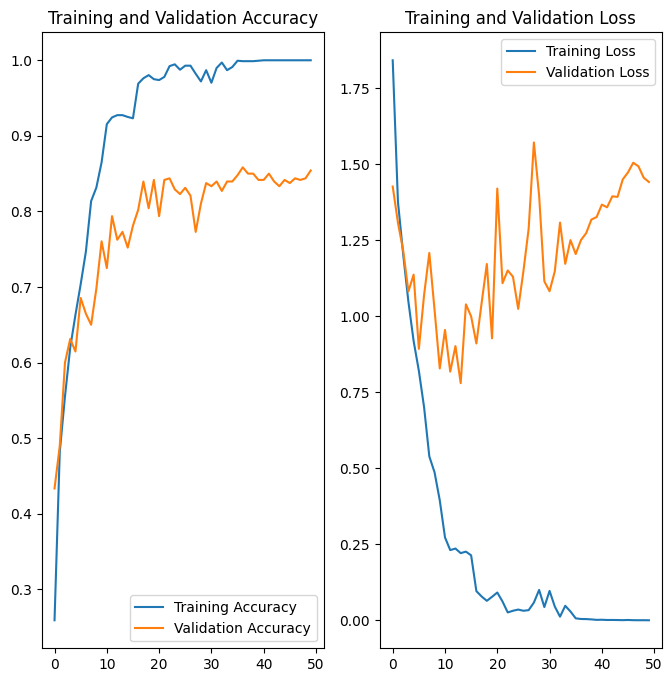

In [25]:
acc = fitted_model.history['accuracy']
val_acc = fitted_model.history['val_accuracy']

loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
best_epoch

37

In [27]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

fitted_hypermodel = hypermodel.fit(train_dataset, validation_data=validation_dataset, epochs=best_epoch)

Epoch 1/37


/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     53/Unknown 9s 168ms/step - accuracy: 0.2113 - loss: 2.1669

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2131 - loss: 2.1593 - val_accuracy: 0.5229 - val_loss: 1.2934
Epoch 2/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.4889 - loss: 1.3180 - val_accuracy: 0.5792 - val_loss: 1.1813
Epoch 3/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.5700 - loss: 1.1440 - val_accuracy: 0.6687 - val_loss: 1.0792
Epoch 4/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.6437 - loss: 0.9808 - val_accuracy: 0.6375 - val_loss: 1.0548
Epoch 5/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.6996 - loss: 0.8424 - val_accuracy: 0.6417 - val_loss: 1.1468
Epoch 6/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.7517 - loss: 0.6898 - val_accuracy: 0.6958 - val_loss: 0.9179
Epoch 7/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8177 - loss: 0.5415 - val_accuracy: 0.7583 - val_loss: 0.7425
Epoch 8/37
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.8662 - loss: 0.3974 - val_accuracy: 0.7708 - va

In [28]:
hypermodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │     4,153,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,547,988 (47.87 MB)

 Trainable params: 4,182,662 (15.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,365,326 (31.91 MB)

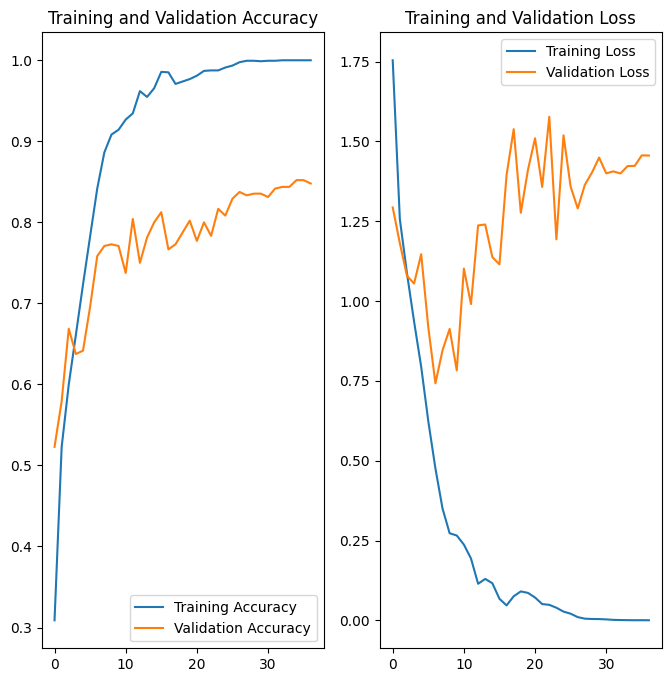

In [30]:
acc = fitted_hypermodel.history['accuracy']
val_acc = fitted_hypermodel.history['val_accuracy']

loss = fitted_hypermodel.history['loss']
val_loss = fitted_hypermodel.history['val_loss']

epochs_range = range(best_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
eval_result = model.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8384 - loss: 1.6941
[test loss, test accuracy]: [1.6635879278182983, 0.8291666507720947]


/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [33]:
img = Image.open('../../data/test/cardboard_test.jpeg').resize((224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This image most likely belongs to cardboard with a 100.00 percent confidence.
[1.0000000e+00 3.3193107e-14 6.5796634e-15 1.0493439e-21 3.4546300e-08
 1.2276791e-12]


In [34]:
best_model = tuner.get_best_models(1)[0]

/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
tuner.get_best_hyperparameters()

In [36]:
eval_result = best_model.evaluate(test_dataset) # accuracy may be lower but loss is better
print("[test loss, test accuracy]:", eval_result)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8290 - loss: 0.6260
[test loss, test accuracy]: [0.643018364906311, 0.800000011920929]


/Users/manntalati/Desktop/Projects/recycling_assistant/ai_recycling_assistant/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [38]:
img = Image.open('../../data/test/cardboard_test.jpeg').resize((224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = best_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(score.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This image most likely belongs to cardboard with a 99.98 percent confidence.
[9.9975127e-01 1.2592117e-04 4.0211354e-08 1.3258292e-09 8.6565655e-05
 3.6202335e-05]


In [39]:
best_model.save(filepath='../models/best_model.keras')

In [40]:
best_model.export("model_dir")

INFO:tensorflow:Assets written to: model_dir/assets


INFO:tensorflow:Assets written to: model_dir/assets


Saved artifact at 'model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  15514918096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15514918288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19389384464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19389386960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19389383888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19389383504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19389386384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19388825040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19388824656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19388824848: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [41]:
import tarfile
with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("../../model_dir", arcname=".")